In [1]:
import ehc_sn as ehc
import matplotlib.pyplot as plt
import torch

import plots

In [2]:
import tomllib as toml

with open("configurations/balanced_network.toml", "rb") as f:
    data = toml.load(f)

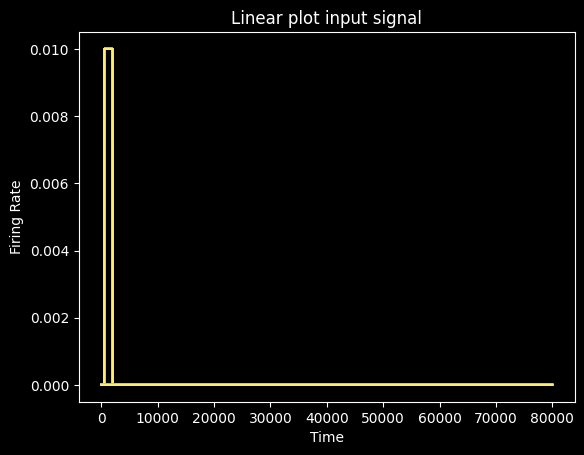

In [3]:
signal_in = torch.zeros(80000, 40).to(ehc.device)
signal_in[500:2000, :20] = 0.01
plots.signal(signal_in.cpu(), "Linear plot input signal")

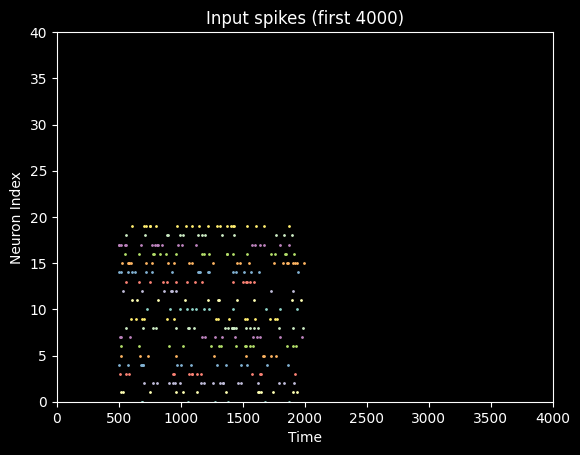

In [4]:
encoder = ehc.encoders.PoissonEncoder()
spikes_in = torch.stack([encoder(x) for x in signal_in])
plots.raster(spikes_in[:4000].cpu(), title="Input spikes (first 4000)")

In [5]:
parameters = ehc.Parameters.model_validate(data)
model = ehc.Network(p=parameters)
model = torch.compile(model)
model.eval()

OptimizedModule(
  (_orig_mod): Network(
    (excitatory): STDPLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.2000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-60., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
    (inhibitory): STDPLayer(p=LIFRefracParameters(lif=LIFParameters(tau_syn_inv=tensor(0.1000, device='cuda:0'), tau_mem_inv=tensor(0.5000, device='cuda:0'), v_leak=tensor(-50., device='cuda:0'), v_th=tensor(-50., device='cuda:0'), v_reset=tensor(-60., device='cuda:0'), method='super', alpha=tensor(0.5000, device='cuda:0')), rho_reset=tensor(5, device='cuda:0')), dt=0.001)
  )
)

W0327 12:52:35.771000 3343 site-packages/torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


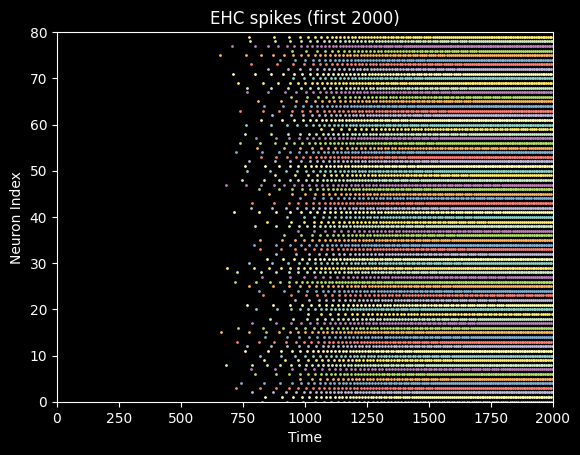

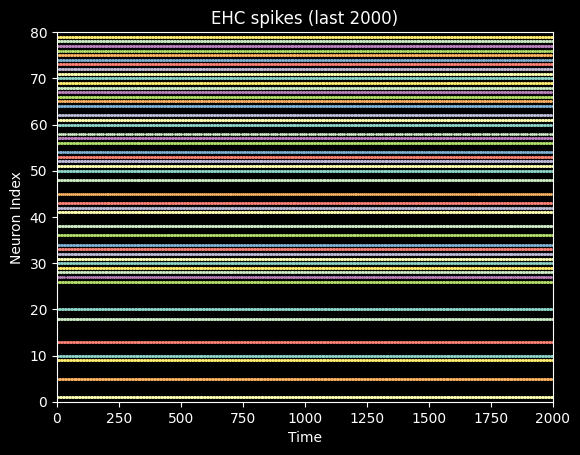

In [6]:
spikes_out = torch.stack([model(x) for x in spikes_in])
plots.raster(spikes_out[:2000].cpu(), title="EHC spikes (first 2000)")
plots.raster(spikes_out[-2000:].cpu(), title="EHC spikes (last 2000)")

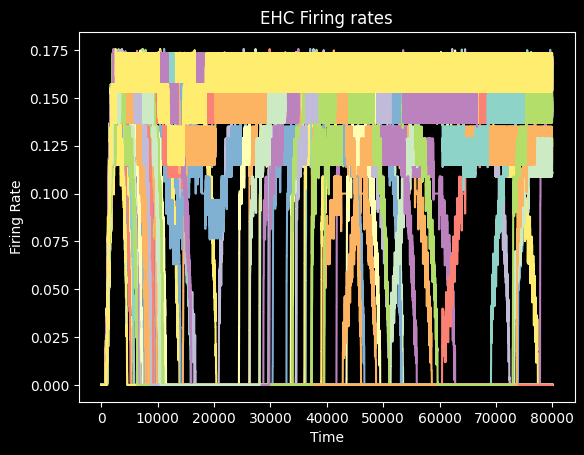

In [7]:
decoder = ehc.decoders.HannDecoder(window_length=100)
signal_out = torch.stack([decoder(x) for x in spikes_out])
signal_out = signal_out.detach()
plots.signal(signal_out.cpu(), title="EHC Firing rates")